In [1]:
import pandas as pd
import numpy as np
import os
import sys
import random

In [2]:
# Pr. Houdart functions

from pandas             import DataFrame
from pandas             import Series
from pandas             import read_csv
from numpy              import array
from numpy              import random


def roc (dataSet: DataFrame, actuals: str, probability: str) -> DataFrame:

    (fpr,tpr,threshold) = roc_curve(array(dataSet[actuals]), array(dataSet[probability]), pos_label = 1)

    returnData = DataFrame(tpr)
    returnData.columns = ["True positive rate"]
    returnData["False positive rate"] = DataFrame(fpr)

    return returnData

def lift (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    summary = cumulativeResponse(dataSet = dataSet, actuals = actuals, probability = probability, precision = precision)

    summary["Lift"] = summary["Cumulative response"] / Series(summary["Average response"]).max()
    summary["Base"] = summary["Average response"] / Series(summary["Average response"]).max()

    return summary[["Quantile","Lift","Base"]]

def cumulativeResponse (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative response"]  = summary["cumulativeTarget"] / summary["cumulativeAll"]
    summary["Average response"]     = Series(summary["cumulativeTarget"]).max() / Series(summary["cumulativeAll"]).max()

    return summary[["Quantile","Cumulative response","Average response"]]

def cumulativeGains (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative gains"]     = summary["cumulativeTarget"] / Series(summary["cumulativeTarget"]).max()
    summary["Base"]                 = summary["Quantile"]

    return summary[["Quantile","Cumulative gains","Base"]]

def equifrequentBinning (dataSet: DataFrame, byColumn: str, into: int) -> DataFrame:

    internalSet = dataSet

    quanitles = []

    for i in range(into):
        quanitles.append(1 / into * (i))

    quantile = internalSet.quantile(quanitles, axis = 0)[byColumn].to_dict()

    internalSet["Bin"] = 0

    for q in quantile:
        upperBound = quantile[q]
        internalSet.loc[internalSet[byColumn] >= upperBound, byColumn + "_bin"] = int(q * into +1)

    return internalSet

def partition (dataFrame : DataFrame, splitStrategy: [float]) -> [DataFrame]:

    def assignPartition (toDataFrame: DataFrame, lowerBound: float, upperBound: float, index: int) -> int:
        if toDataFrame["random"] >= lowerBound * observations and toDataFrame["random"] < upperBound * observations:
            return index
        else:
            return int(toDataFrame["Split"])

    if type(splitStrategy) != list:
        raise KeyError("Split strategy must be an array of floating point values.")
    elif sum(splitStrategy) != 1:
        raise ValueError("Split strategy must sum to 1.")
    else:
        observations = dataFrame.shape[0]
        partitions   = len(splitStrategy)

        cumulativeSplit = 0

        data = dataFrame.copy()
        data["random"] = random.permutation(observations)
        data["Split"]  = 0

    for index, split in enumerate(splitStrategy):
        lowerSplit = cumulativeSplit
        upperSplit = cumulativeSplit + split + 1
        cumulativeSplit += split
        data["Split"] = data.apply(lambda x: assignPartition(x,lowerSplit,upperSplit,index+1), axis = 1)

    partitions = []

    for i in range(len(splitStrategy)):
        partitions.append(data.loc[data["Split"] == i+1].drop(["Split","random"], axis = 1).reset_index(drop = True))

    return partitions

In [29]:
gift_base_6169 = pd.read_csv("./Data/gift_base_6169.csv")
gift_base_7244 = pd.read_csv("./Data/gift_base_7244.csv")
gift_base_7362 = pd.read_csv("./Data/gift_base_7362.csv")

In [30]:
print(gift_base_6169.columns)
print(gift_base_7362.columns)

Index(['Unnamed: 0', 'donorID', 'campaignID', 'frequency_donor',
       'total_donated', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'total_amount_1_month',
       'total_freq_1_month', 'total_amount_2_month', 'total_freq_2_month',
       'total_amount_3_month', 'total_freq_3_month', 'total_amount_4_month',
       'total_freq_4_month', 'total_amount_5_month', 'total_freq_5_month',
       'total_amount_6_month', 'total_freq_6_month', 'Recency_dono',
       'total_donated_during_dv', 'gender', 'dateOfBirth', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Missing', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'region_Flanders',
       'region_Missing', 'region_Wallonia', 'language_FR', 'language_NL',
       'total_freq_till_now', 'total_amount_till_now', 'freq_out_campaign'

In [31]:
print(gift_base_6169.shape)
print(gift_base_7244.shape)
print(gift_base_7362.shape)

(34888, 60)
(25645, 60)
(26522, 58)


In [32]:
gift_base_6169.drop("Unnamed: 0", axis=1,inplace=True)
gift_base_6169.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,donated_more_than30_duringdv,Age
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,178.49,1.0,12.39,11.0,166.10,0.0,0.0,0,50.0
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,20.00,0.0,0.00,1.0,20.00,20.0,1.0,0,66.0
2,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,716.22,1.0,24.79,25.0,691.43,0.0,0.0,0,66.0
3,100008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,124.37,0.0,0.00,3.0,124.37,0.0,0.0,0,81.0
4,100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,326.78,0.0,0.00,19.0,326.78,0.0,0.0,0,86.0


In [33]:
gift_base_6169.shape

(34888, 59)

In [35]:
gift_base_6169.describe()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,donated_more_than30_duringdv,Age
count,3.488800e+04,259.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.00000,268.000000,...,34869.000000,3.486900e+04,34869.000000,3.486900e+04,34869.000000,3.486900e+04,34869.000000,34869.000000,34888.000000,34874.000000
mean,1.210759e+05,5129.806950,2.156716,39.045933,1.365672,0.149254,4.535821,8.382146,2.08694,1.572220,...,4.212366,2.982621e+02,0.310362,1.233043e+02,3.902005,1.749578e+02,8.475181,0.341679,0.027431,48.547629
std,1.452766e+04,158.567648,2.342746,55.640525,7.242758,2.443389,21.710559,19.279230,8.94696,8.305923,...,7.816252,2.520205e+04,3.946533,2.142113e+04,6.519260,1.327802e+04,26.075060,1.064179,0.163337,15.901147
min,1.000010e+05,4828.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,5.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,20.000000
25%,1.104615e+05,4991.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,2.479000e+01,0.000000,0.000000e+00,1.000000,2.200000e+01,0.000000,0.000000,0.000000,36.000000
50%,1.207525e+05,5062.000000,1.000000,24.895000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,2.000000,4.000000e+01,0.000000,0.000000e+00,2.000000,3.900000e+01,0.000000,0.000000,0.000000,47.000000
75%,1.314162e+05,5326.000000,2.000000,50.000000,0.000000,0.000000,0.000000,4.290000,0.00000,0.000000,...,4.000000,1.095800e+02,0.000000,0.000000e+00,4.000000,1.000000e+02,0.000000,0.000000,0.000000,59.000000
max,1.474536e+06,5434.000000,12.000000,575.000000,50.000000,40.000000,275.000000,162.500000,50.00000,81.000000,...,238.000000,4.000030e+06,228.000000,4.000000e+06,235.000000,2.479000e+06,1000.000000,55.000000,1.000000,129.000000


In [36]:
gift_base_6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   donorID                         34888 non-null  int64  
 1   campaignID                      259 non-null    float64
 2   frequency_donor                 268 non-null    float64
 3   total_donated                   268 non-null    float64
 4   C1                              268 non-null    float64
 5   C2                              268 non-null    float64
 6   C3                              268 non-null    float64
 7   C4                              268 non-null    float64
 8   C5                              268 non-null    float64
 9   C6                              268 non-null    float64
 10  C7                              268 non-null    float64
 11  C8                              268 non-null    float64
 12  C9                              

In [37]:
gift_base_6169.isna().sum().sum()

1038124

In [38]:
gift_base_7362.columns

Index(['Unnamed: 0', 'donorID', 'campaignID', 'frequency_donor',
       'total_donated', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'total_amount_1_month',
       'total_freq_1_month', 'total_amount_2_month', 'total_freq_2_month',
       'total_amount_3_month', 'total_freq_3_month', 'total_amount_4_month',
       'total_freq_4_month', 'total_amount_5_month', 'total_freq_5_month',
       'total_amount_6_month', 'total_freq_6_month', 'Recency_dono', 'gender',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'Unnamed: 0.1', 'total_freq_till_now',
       'total_amount_till_now', 'freq_out_campaign', 'amount_out_campaign',
 

In [39]:
#gift_base_6169.columns

cols_to_fill = ['C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono','total_donated_during_dv']

cols_to_fill_62 = ['C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono']       

for col in cols_to_fill:
    gift_base_6169[col] = gift_base_6169[col].fillna(0)

for col in cols_to_fill:
    gift_base_7244[col] = gift_base_7244[col].fillna(0)    

for col in cols_to_fill_62:
    gift_base_7362[col] = gift_base_7362[col].fillna(0)      

In [40]:
cols_to_fill = ['province_Brussels','province_East Flanders','province_Flemish Brabant'
        ,'province_Hainaut','province_Liege','province_Limburg'
        ,'province_Luxembourg',	'province_Missing',	'province_Namur'
        ,'province_Walloon Brabant','province_West Flanders'
        ,'region_Flanders',	'region_Missing', 'region_Wallonia'
        ,'language_FR',	'language_NL', 'total_freq_till_now'
        ,'total_amount_till_now', 'freq_out_campaign'
        ,'amount_out_campaign', 'freq_in_campaign'
        ,'amount_in_campaign','total_amount_till_last_3_years'
        ,'total_freq_till_last_3_years','frequency_donor','total_donated']


for col in cols_to_fill:
    gift_base_6169[col] = gift_base_6169[col].fillna(0)

for col in cols_to_fill:
    gift_base_7244[col] = gift_base_7244[col].fillna(0)    

for col in cols_to_fill:
    gift_base_7362[col] = gift_base_7362[col].fillna(0)

In [41]:
#Fillnas
gift_base_6169["gender"].fillna(random.choice(gift_base_6169['gender'][gift_base_6169['gender'].notna()]), inplace=True)
gift_base_6169["Age"].fillna(random.choice(gift_base_6169['Age'][gift_base_6169['Age'].notna()]), inplace=True)

gift_base_7244["gender"].fillna(random.choice(gift_base_7244['gender'][gift_base_7244['gender'].notna()]), inplace=True)
gift_base_7244["Age"].fillna(random.choice(gift_base_7244['Age'][gift_base_7244['Age'].notna()]), inplace=True)

gift_base_7362["gender"].fillna(random.choice(gift_base_7362['gender'][gift_base_7362['gender'].notna()]), inplace=True)
gift_base_7362["Age"].fillna(random.choice(gift_base_7362['Age'][gift_base_7362['Age'].notna()]), inplace=True)


In [42]:
cols_to_fill = ['donorID', 'campaignID', 'frequency_donor', 'total_donated', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'total_donated_during_dv', 'gender', 'dateOfBirth',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 'total_amount_till_last_3_years',
       'total_freq_till_last_3_years']

cols_to_fill_62 = ['donorID', 'campaignID', 'frequency_donor', 'total_donated', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'gender', 
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 'total_amount_till_last_3_years',
       'total_freq_till_last_3_years']

for col in cols_to_fill:
    gift_base_6169[col] = gift_base_6169[col].fillna(0)

for col in cols_to_fill:
    gift_base_7244[col] = gift_base_7244[col].fillna(0)    

for col in cols_to_fill_62:
    gift_base_7362[col] = gift_base_7362[col].fillna(0)    

In [43]:
#gift_base_6169['campaignID'] = 
gift_base_6169["campaign_flag"] = np.where(gift_base_6169.campaignID.isna(),1,0)

gift_base_7244["campaign_flag"] = np.where(gift_base_7244.campaignID.isna(),1,0)

gift_base_7362["campaign_flag"] = np.where(gift_base_7362.campaignID.isna(),1,0)

In [44]:
gift_base_6169.drop(['dateOfBirth','campaignID','total_donated_during_dv','donorID'], axis=1, inplace=True)

gift_base_7244.drop(['dateOfBirth','campaignID','total_donated_during_dv','donorID'], axis=1, inplace=True)

In [45]:
gift_base_6169.rename({'donated_more_than30_duringdv': 'target'}, axis=1, inplace=True)

gift_base_7244.rename({'donated_more_than30_duringdv': 'target'}, axis=1, inplace=True)

gift_base_7362.rename({'donated_more_than30_duringdv': 'target'}, axis=1, inplace=True)

gift_base_6169.head()

,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,C7,C8,...,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,target,Age,campaign_flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,178.49,1.0,12.39,11.0,166.10,0.0,0.0,0,50.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.00,0.0,0.00,1.0,20.00,20.0,1.0,0,66.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,716.22,1.0,24.79,25.0,691.43,0.0,0.0,0,66.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124.37,0.0,0.00,3.0,124.37,0.0,0.0,0,81.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,326.78,0.0,0.00,19.0,326.78,0.0,0.0,0,86.0,0


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#for having clasification reports
from sklearn.metrics import classification_report,  roc_curve, auc, confusion_matrix, roc_auc_score

# Cross Validation Score
from sklearn.model_selection import cross_val_score

#an algotithm to normalize the numbers by dividing them to thairs std
from scipy.cluster.vq import whiten

from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf

#import lightgbm as lgb
import h2o
from h2o.automl import H2OAutoML

from imblearn.under_sampling import RandomUnderSampler

In [47]:
from sklearn.utils import shuffle
gift_base_6169 = shuffle(gift_base_6169, random_state=42).reset_index(drop=True)
gift_base_6169.head()

,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,C7,C8,...,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,target,Age,campaign_flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,239.57,0.0,0.0,10.0,239.57,0.0,0.0,0,50.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80.00,0.0,0.0,4.0,80.00,0.0,0.0,0,45.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.00,0.0,0.0,1.0,50.00,0.0,0.0,0,53.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.00,0.0,0.0,1.0,25.00,0.0,0.0,0,67.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.00,0.0,0.0,4.0,40.00,0.0,0.0,0,75.0,0


In [51]:
gift_base_7244.columns

Index(['Unnamed: 0', 'frequency_donor', 'total_donated', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'gender', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 

In [68]:
#Random campaign Response rate for test data
import sqldf
print(sqldf.run("""
select
target,
count(*)
from gift_base_7244
group by 1
"""))
print((217/25428)*100)

C:\Users\irana\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


   target  count(*)
0       0     25428
1       1       217
0.8533899638194117


In [69]:
#Random campaign Response rate for train data
import sqldf
print(sqldf.run("""
select
target,
count(*) as count
from gift_base_6169
group by 1
"""))
print((957/33931)*100)

C:\Users\irana\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


   target  count
0       0  33931
1       1    957
2.8204296955586337


In [22]:
donators = sqldf.run("""
select
*
from gift_base_6169
where target =1
""")

C:\Users\irana\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [23]:
not_donators = sqldf.run("""
select
*
from gift_base_6169
where target =0
ORDER BY RANDOM()
limit 7000
""")

In [24]:
not_donators = sqldf.run("""
select
*
from gift_base_6169
where target =0
ORDER BY RANDOM()
limit 7000
""")

In [25]:
test_camp = sqldf.run("""
select * from not_donators
union 
select * from donators
""")

gift_base_6169 = shuffle(test_camp)

In [26]:
gift_base_6169 = test_camp.reset_index(drop=True)
gift_base_6169 = test_camp.drop("level_0", axis=1)
gift_base_6169 = test_camp.drop("index", axis=1)

In [27]:
gift_base_6169

,level_0,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,C7,...,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,target,Age,campaign_flag
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.943,0.0,0.0,1.0,20.943,0.0,0.0,1,73.0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.170,0.0,0.0,13.0,147.170,0.0,0.0,0,52.0,0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,87.425,0.0,0.0,2.0,87.425,0.0,0.0,1,53.0,0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.480,0.0,0.0,2.0,12.480,0.0,0.0,0,54.0,0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.060,0.0,0.0,2.0,60.060,0.0,0.0,1,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7952,6995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.790,0.0,0.0,1.0,24.790,0.0,0.0,0,32.0,0
7953,6996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.000,0.0,0.0,1.0,35.000,0.0,0.0,0,23.0,0
7954,6997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,74.370,0.0,0.0,3.0,74.370,0.0,0.0,0,46.0,0
7955,6998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.790,0.0,0.0,1.0,24.790,0.0,0.0,0,44.0,0


In [28]:
gift_base_6169.drop("level_0", axis=1,inplace=True)

In [29]:
from sklearn.utils import shuffle
donators = shuffle(donators)
not_donators = shuffle(not_donators)

In [30]:
train = gift_base_6169
test = gift_base_7244
unseen = gift_base_7362

In [31]:
print(train.shape)

print(test.shape)

(7957, 56)
(25645, 57)


In [32]:
x_cols = ['frequency_donor', 'total_donated', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'gender',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 'total_amount_till_last_3_years',
       'total_freq_till_last_3_years', 'Age', 'campaign_flag']

y_col = ['target']

In [33]:
X = train[x_cols]
y = train[y_col]

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y.values.ravel(),test_size=0.2 ,shuffle=True)

In [56]:
# instanciate the models
#tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(max_iter = 2000)
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
XG           = XGBClassifier()
neuralNetR    = MLPRegressor()
#neuralNetC    = MLPClassifier()
#neighbors    = KNeighborsClassifier()

# create a dict to loop through the models later on
models = {
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "XG"           :XG

          #"neuralNetR"     :MLPRegressor,
          #"neuralNetC"     :MLPClassifier
         }

In [57]:
# fit the models
for model in models:
    random.seed=42
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
[14:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG has been trained successfully


In [58]:
# AUC
performances = {}

#test[x_cols]
#test[y_col]

for model in models:
    random.seed=42
    predictions   = models[model].predict(test[x_cols])
    probabilities = pd.DataFrame(models[model].predict_proba(test[x_cols]))[1]
    accuracy      = accuracy_score(test[y_col],predictions)
    auc           = roc_auc_score(np.array(test[y_col]),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

,logistic,randomForest,boostedTree,XG
Accuracy,0.986235,0.974225,0.984129,0.971612
AUC,0.638913,0.688115,0.683388,0.718444


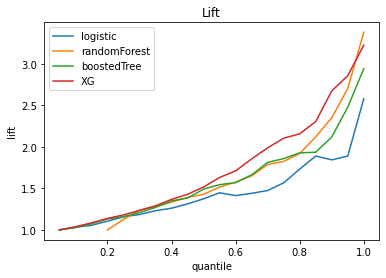

In [59]:
import shutup
shutup.please()
target='target'
lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(test[y_col]).copy() 

for (index,model) in enumerate(models):
    random.seed=42
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(test[x_cols]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))



for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"], label=model)
    plt.gca().invert_xaxis()
    plt.xlabel("quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(loc="upper left")



In [60]:
rf_feat = pd.DataFrame(randomForest.feature_importances_, index=X.columns, columns=["Feature importance"])
xg_feat = pd.DataFrame(XG.feature_importances_, index=X.columns, columns=["Feature importance"])
bt_feat = pd.DataFrame(boostedTree.feature_importances_, index=X.columns, columns=["Feature importance"])

In [61]:
feat_imp = pd.concat([rf_feat,xg_feat,bt_feat], axis=1)
fi_mean = feat_imp.transpose().describe().iloc[1:2].transpose().round(4)

feat_imp = pd.concat([feat_imp,fi_mean], axis=1)
feat_imp = feat_imp.sort_values(by=['mean'], ascending=False).head(15)

In [62]:
feat_imp

,Feature importance,Feature importance,Feature importance,mean
total_amount_till_now,0.239617,0.096744,0.306818,0.2144
amount_in_campaign,0.229457,0.091868,0.163373,0.1616
gender,0.046345,0.272442,0.113580,0.1441
Age,0.190156,0.053671,0.147700,0.1305
total_amount_till_last_3_years,0.076969,0.090426,0.178714,0.1154
amount_out_campaign,0.026677,0.060012,0.036502,0.0411
total_freq_till_now,0.058892,0.049415,0.012568,0.0403
freq_in_campaign,0.055486,0.040851,0.016417,0.0376
total_freq_till_last_3_years,0.019918,0.048283,0.017693,0.0286
province_West Flanders,0.017047,0.040507,0.000000,0.0192


In [63]:
x_cols = feat_imp.index

y_col = ['target']

<AxesSubplot:>

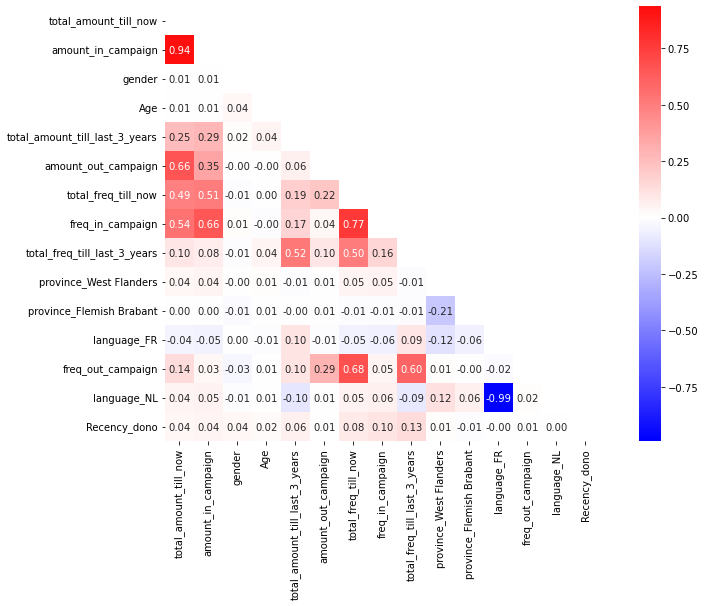

In [64]:
# Compute the correlation matrix
corr = train[x_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(corr, mask=mask, cmap=plt.cm.bwr, center=0, annot=True, fmt='.2f', square=True)

In [65]:
X = train[x_cols]
y = train[y_col]

X_train,X_test,y_train,y_test=train_test_split(X,y.values.ravel(),test_size=0.2 ,shuffle=True)

In [66]:
# fit the models
random.seed=42
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
[14:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG has been trained successfully


In [67]:
# AUC
performances = {}

#test[x_cols]
#test[y_col]

for model in models:
    random.seed=42
    predictions   = models[model].predict(X_test[x_cols])
    probabilities = pd.DataFrame(models[model].predict_proba(X_test[x_cols]))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(np.array(y_test),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

,logistic,randomForest,boostedTree,XG
Accuracy,0.883794,0.906407,0.908291,0.919598
AUC,0.733496,0.863748,0.877909,0.905663


In [68]:
# AUC
performances = {}

#test[x_cols]
#test[y_col]



for model in models:
    random.seed=42
    predictions   = models[model].predict(test[x_cols])
    probabilities = pd.DataFrame(models[model].predict_proba(test[x_cols]))[1]
    accuracy      = accuracy_score(test[y_col],predictions)
    auc           = roc_auc_score(np.array(test[y_col]),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

,logistic,randomForest,boostedTree,XG
Accuracy,0.985455,0.973406,0.984792,0.973952
AUC,0.631775,0.697751,0.703551,0.717677


In [69]:
XG.predict_proba(test[x_cols])[:,1]

array([0.06633651, 0.00775184, 0.14251424, ..., 0.01385786, 0.00536159,
       0.01789398], dtype=float32)

<Figure size 504x504 with 0 Axes>

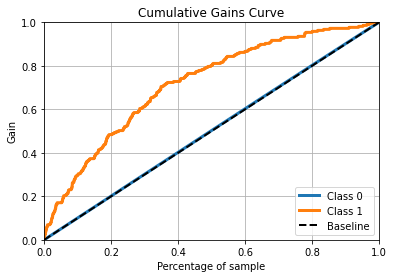

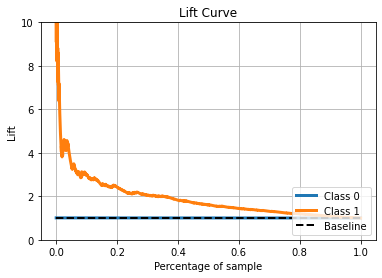

In [301]:
import scikitplot as skplt
pred = (XG.predict_proba(test[x_cols]) + boostedTree.predict_proba(test[x_cols]))/2

plt.figure(figsize=(7,7))
skplt.metrics.plot_cumulative_gain(test[y_col].values, pred)
skplt.metrics.plot_lift_curve(test[y_col].values, pred)
plt.ylim(0,10)
plt.show()

<Figure size 504x504 with 0 Axes>

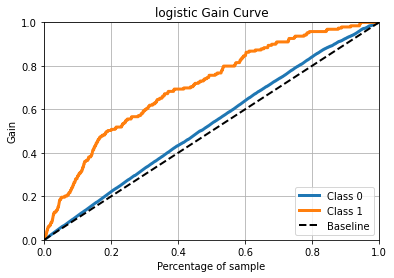

<Figure size 504x504 with 0 Axes>

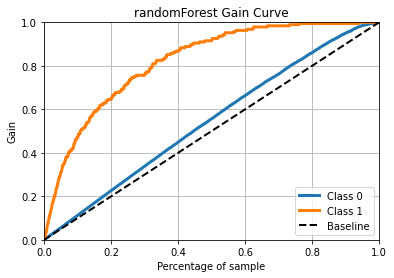

<Figure size 504x504 with 0 Axes>

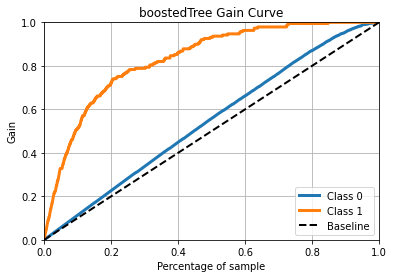

<Figure size 504x504 with 0 Axes>

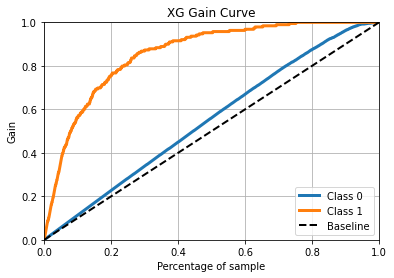

In [71]:
import scikitplot as skplt

target='target'
lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(test[y_col]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(test[x_cols]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))


for model in models:
    pred = models[model].predict_proba(X_test[x_cols])
    plt.figure(figsize=(7,7))
    skplt.metrics.plot_cumulative_gain(y_test, pred)
    plt.title(model + " Gain Curve")
    plt.show()

<Figure size 504x504 with 0 Axes>

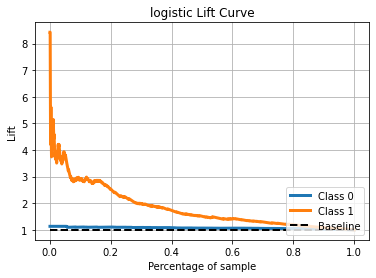

<Figure size 504x504 with 0 Axes>

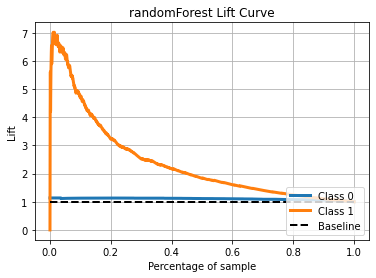

<Figure size 504x504 with 0 Axes>

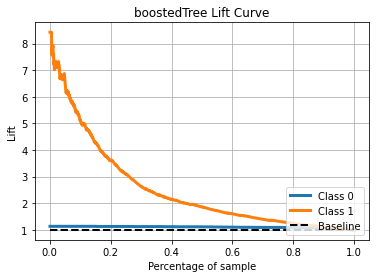

<Figure size 504x504 with 0 Axes>

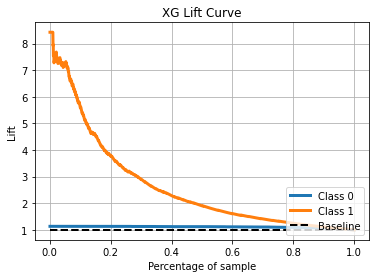

In [72]:
target='target'
lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(test[y_col]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(test[x_cols]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))


for model in models:
    pred = models[model].predict_proba(X_test[x_cols])
    plt.figure(figsize=(7,7))
    skplt.metrics.plot_lift_curve(y_test, pred)
    plt.title(model + " Lift Curve")
    plt.show()

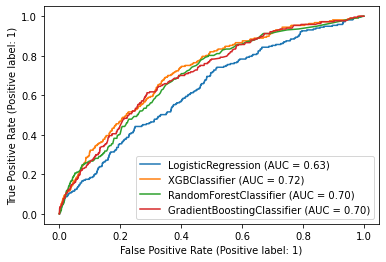

In [73]:
from sklearn.metrics import plot_roc_curve

classifiers = [logistic, XG, randomForest, boostedTree]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, test[x_cols], test[y_col], ax=ax)

In [74]:
XG_Proba = XG.predict_proba(test[x_cols])[:,1]

In [75]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(test[y_col], XG_Proba)

#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

Text(69.0, 0.5, 'Truth')

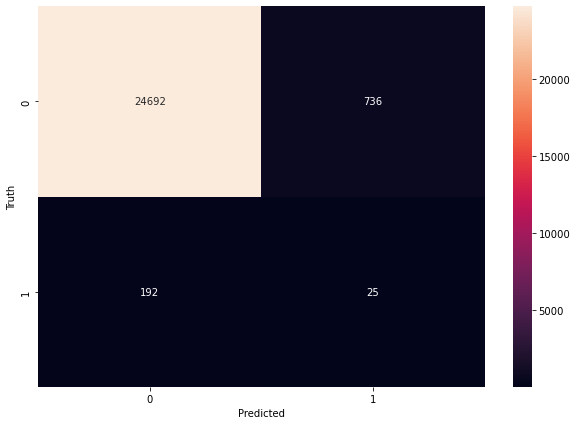

In [76]:
import tensorflow as tf
import seaborn as sn
#pred = pred_7244["predict"]

pred = np.where(XG_Proba>0.4,1,0)

cm = tf.math.confusion_matrix(labels=test[y_col],predictions=pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [149]:
XG_proba = XG.predict_proba(test[x_cols])
boosted_proba = boostedTree.predict_proba(test[x_cols])
#logistic = logistic.predict_proba(test[x_cols])

In [150]:
combined = (np.array(XG_proba) + np.array(boosted_proba)) / 2

In [83]:
roc_auc_score(np.array(test[y_col]),combined[:,1])

0.7196977605150968

In [228]:
combined = combined[:,1]

<Figure size 504x504 with 0 Axes>

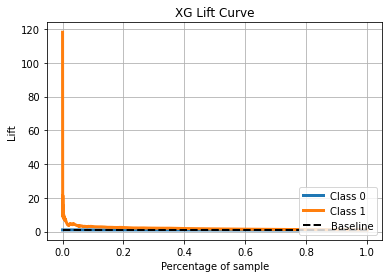

In [287]:
pred = (np.array(XG_proba) + np.array(boosted_proba)) / 2
plt.figure(figsize=(7,7))
skplt.metrics.plot_lift_curve(test[y_col], pred)
plt.title(model + " Lift Curve")
plt.show()

In [257]:
def cumulativeResponse (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:
    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)
    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"] = 1
    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)
    summary["cumulativeTarget"] = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"] = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative response"] = summary["cumulativeTarget"] / summary["cumulativeAll"]
    summary["Average response"] = Series(summary["cumulativeTarget"]).max() / Series(summary["cumulativeAll"]).max()
    summary['Quantile'] = 1 - summary['Quantile']
    return summary[["Quantile","Cumulative response","Average response"]]

In [277]:
gift_base_7244 = pd.read_csv("./Data/gift_base_7244.csv")
com_res_df = gift_base_7244
com_res_df.drop("Unnamed: 0", axis=1, inplace=True)
com_res_df = com_res_df[["donated_more_than30_duringdv"]]
com_res_df["proba"] = np.round(combined,1)
com_res_df = com_res_df.rename(columns={"donated_more_than30_duringdv": "target"})

In [281]:
res = cumulativeResponse(com_res_df, 'target', 'proba')
res
# Change to Percent
res['Cumulative response'] = res['Cumulative response'] * 1000
res['Average response'] = res['Average response'] * 1000
#res

In [282]:
res

,Quantile,Cumulative response,Average response
4,0.00,36.635007,8.461688
3,0.02,29.005525,8.461688
2,0.04,23.345059,8.461688
1,0.12,16.374635,8.461688
0,0.36,8.461688,8.461688


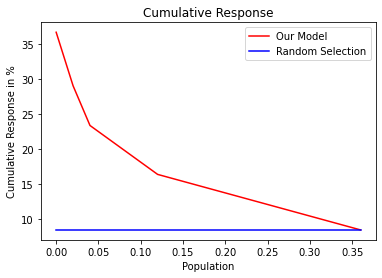

In [283]:
fig, ax = plt.subplots()
ax.plot(res['Quantile'], res['Cumulative response'], color = 'r', label = 'Our Model')
ax.plot(res['Quantile'], res['Average response'], color = 'b', label = 'Random Selection')
ax.set_xlabel('Population')
ax.set_ylabel('Cumulative Response in %')
ax.set_title('Cumulative Response')
ax.legend()
plt.show()

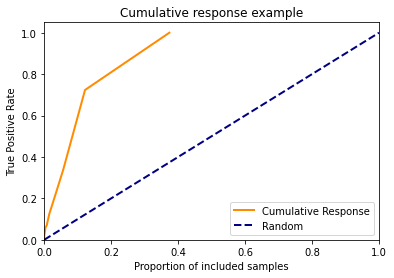

In [262]:
y_test = com_res_df['target']
y_proba = com_res_df['proba']
_, tpr, thresholds = roc_curve(y_test, y_proba)

prop_included = []
for T in thresholds:
    y_pred = (y_proba > np.array(T)).astype(int)
    prop_included.append(sum(y_pred)/ len(y_test))

plt.figure()
lw = 2
plt.plot(prop_included, tpr, color='darkorange',
         lw=lw, label='Cumulative Response')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportion of included samples')
plt.ylabel('True Positive Rate')
plt.title('Cumulative response example')
plt.legend(loc="lower right")
plt.show()

In [85]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(test[y_col], combined)

#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

Text(69.0, 0.5, 'Truth')

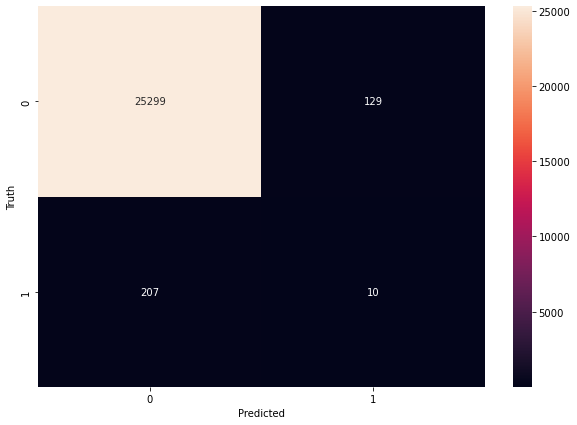

In [87]:
import tensorflow as tf
import seaborn as sn

pred = np.where(combined>0.6,1,0)

cm = tf.math.confusion_matrix(labels=test[y_col],predictions=pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

<Figure size 504x504 with 0 Axes>

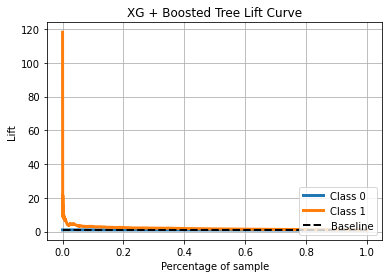

In [89]:
plt.figure(figsize=(7,7))

pr =  (np.array(XG_proba) + np.array(boosted_proba)) / 2
skplt.metrics.plot_lift_curve(test[y_col], pr)
plt.title("XG + Boosted Tree Lift Curve")
plt.show()

In [302]:
h2o.init(nthreads = -1,max_mem_size_GB = 2)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 hours 53 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_irana_ly71w5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.529 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
train = gift_base_6169
test = gift_base_7244

In [ ]:
hx_cols = x_cols + y_col
#Create H2O frame
h_train =  h2o.H2OFrame(train)
h_test = h2o.H2OFrame(test)

y = "target"

train, test =h_train.split_frame(ratios=[0.25], seed = 42)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
aml = H2OAutoML(seed=42, max_models=15, max_runtime_secs_per_model=60, max_runtime_secs=360)

In [ ]:
aml.train(training_frame=h_train, y=y)

AutoML progress: |
08:33:56.828: AutoML: XGBoost is not available; skipping it.
08:33:56.869: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
08:33:56.869: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_5_AutoML_1_20211207_83356

No model summary for this model

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 0.015979490317435317
RMSE: 0.12641000877080627
MAE: 0.05855674176928879
RMSLE: 0.08493971829502146
Mean Residual Deviance: 0.015979490317435317

ModelMetricsRegression: stackedensemble
** Reported on cross-validation data. **

MSE: 0.05766078203741378
RMSE: 0.24012659585604795
MAE: 0.11273857291205966
RMSLE: 0.16815136544177312
Mean Residual Deviance: 0.05766078203741378


In [ ]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_5_AutoML_1_20211207_83356,0.0576608,0.240127,0.0576608,0.112739,0.168151
StackedEnsemble_AllModels_4_AutoML_1_20211207_83356,0.0589208,0.242736,0.0589208,0.136206,0.171909
StackedEnsemble_AllModels_3_AutoML_1_20211207_83356,0.0590203,0.242941,0.0590203,0.136365,0.172063
StackedEnsemble_AllModels_6_AutoML_1_20211207_83356,0.059091,0.243086,0.059091,0.135492,0.171209
StackedEnsemble_BestOfFamily_5_AutoML_1_20211207_83356,0.0608636,0.246706,0.0608636,0.11846,0.172633
StackedEnsemble_BestOfFamily_4_AutoML_1_20211207_83356,0.0610527,0.247088,0.0610527,0.139145,0.175484
StackedEnsemble_BestOfFamily_6_AutoML_1_20211207_83356,0.0610798,0.247143,0.0610798,0.138276,0.175193
GBM_grid_1_AutoML_1_20211207_83356_model_3,0.0612147,0.247416,0.0612147,0.137203,0.175062
StackedEnsemble_AllModels_2_AutoML_1_20211207_83356,0.0631769,0.25135,0.0631769,0.140615,0.177242
StackedEnsemble_AllModels_1_AutoML_1_20211207_83356,0.0640029,0.252988,0.0640029,0.141923,0.178553


In [ ]:
m = h2o.get_model("GBM_grid_1_AutoML_1_20211207_83356_model_3")

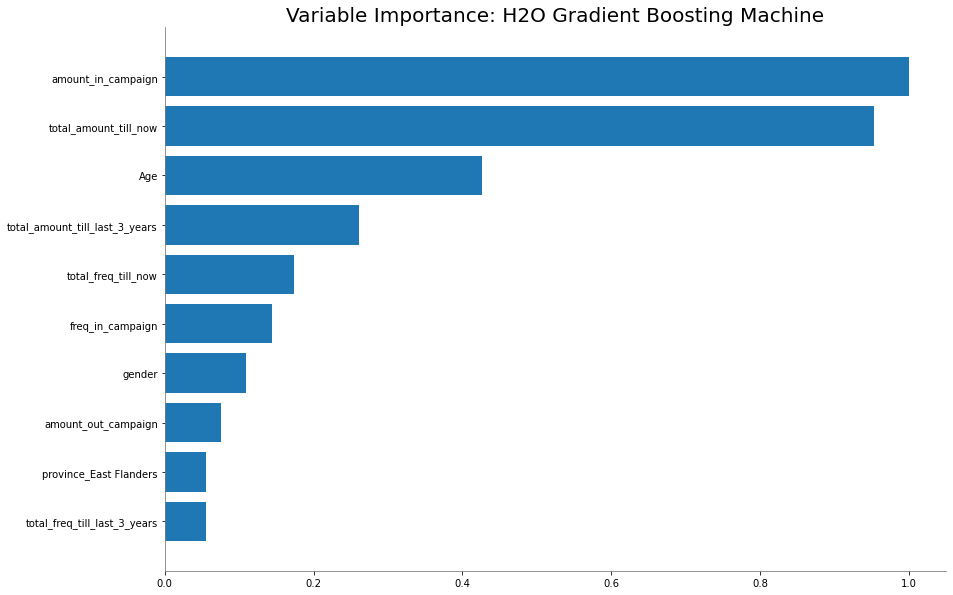

In [ ]:
m.varimp_plot()

In [ ]:
var_imp = m.varimp(use_pandas=True)
var_imp

,variable,relative_importance,scaled_importance,percentage
0,amount_in_campaign,1040.398926,1.000000,0.287885
1,total_amount_till_now,991.684998,0.953178,0.274405
2,Age,443.768372,0.426537,0.122793
3,total_amount_till_last_3_years,271.989838,0.261428,0.075261
4,total_freq_till_now,180.051193,0.173060,0.049821
5,freq_in_campaign,150.126541,0.144297,0.041541
6,gender,113.091904,0.108701,0.031293
7,amount_out_campaign,79.231720,0.076155,0.021924
8,province_East Flanders,58.117847,0.055861,0.016082
9,total_freq_till_last_3_years,57.275124,0.055051,0.015848


In [ ]:
imp_vars = np.array(var_imp[var_imp.scaled_importance>0.021945]["variable"])
imp_vars

array(['amount_in_campaign', 'total_amount_till_now', 'Age',
       'total_amount_till_last_3_years', 'total_freq_till_now',
       'freq_in_campaign', 'gender', 'amount_out_campaign',
       'province_East Flanders', 'total_freq_till_last_3_years',
       'freq_out_campaign', 'province_Flemish Brabant',
       'province_West Flanders'], dtype=object)

In [ ]:
import shap
shap.initjs()

### SHAP on XG Boost

In [ ]:
shap_train_X = gift_base_6169[x_cols]
shap_test_X = gift_base_7244[x_cols]


shap_train_y = gift_base_6169[y_col]
shap_test_y = gift_base_7244[y_col]

#X_train,X_test,y_train,y_test=train_test_split(X,y.values.ravel(),test_size=0.2 ,shuffle=True)

In [ ]:
# initialize explainer
explainer = shap.Explainer(XG, shap_train_X)

# compute shapley values 
shap_values = explainer.shap_values(shap_test_X)

 99%|===================| 25314/25645 [01:00<00:00]       

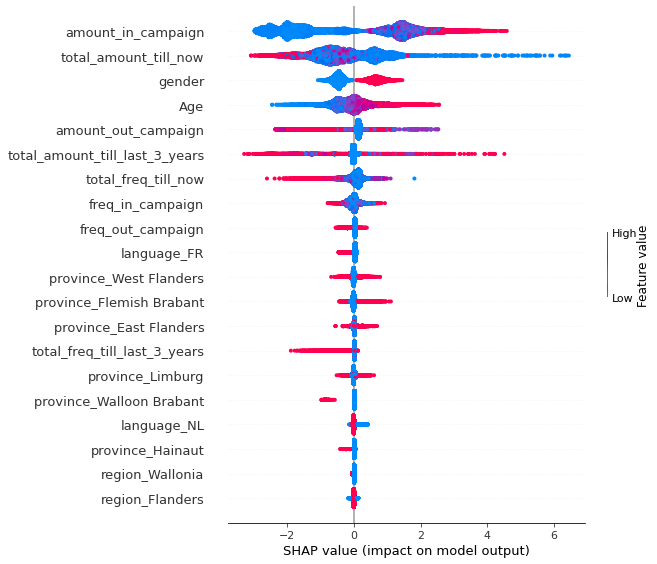

In [ ]:
shap.summary_plot(shap_values, shap_test_X, class_names=["0", "1"])

In [ ]:
import PyALE
# adapt PyALE.ale function to incorporate classification models 
# reference: https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/ALE%20plots%20for%20classification%20models.html
def ale(target=None, print_meanres=False, **kwargs):
    if target is not None:
        class clf():
            def __init__(self, classifier):
                self.classifier = classifier
            def predict(self, X):
                return(self.classifier.predict_proba(X)[:, target])
        clf_dummy = clf(kwargs["model"])
        kwargs["model"] = clf_dummy
    if (print_meanres & len(kwargs["feature"])==1):
        mean_response = np.mean(kwargs["model"].predict(kwargs["X"]), axis=0)
        print(f"Mean response: {mean_response:.5f}")
    return PyALE.ale(**kwargs)

In [ ]:
shap_test_X.columns

Index(['frequency_donor', 'total_donated', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'total_amount_1_month',
       'total_freq_1_month', 'total_amount_2_month', 'total_freq_2_month',
       'total_amount_3_month', 'total_freq_3_month', 'total_amount_4_month',
       'total_freq_4_month', 'total_amount_5_month', 'total_freq_5_month',
       'total_amount_6_month', 'total_freq_6_month', 'Recency_dono', 'gender',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 'total_amount_

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.06211


PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.06211


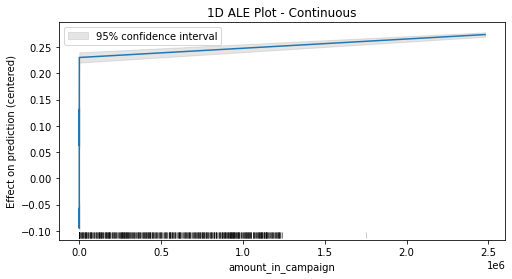

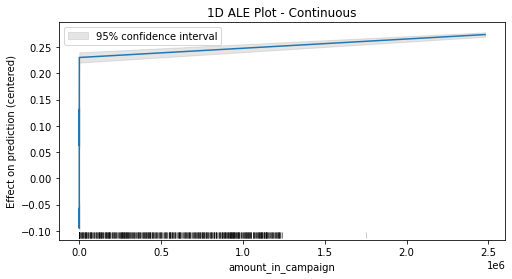

In [ ]:
# ALE plot 1D - petal length, target=1 (versicolor)
ale_petal_length = ale(
    X=shap_test_X,
    model=XG,
    feature=["amount_in_campaign"],
    include_CI=True,
    target=1,
    print_meanres=True
)

# ALE plot 1D - petal length, target=1 (versicolor)
ale_petal_length = ale(
    X=shap_test_X,
    model=XG,
    feature=["amount_in_campaign"],
    include_CI=True,
    target=1,
    print_meanres=True
)


In [ ]:
shap_train_X.columns

Index(['frequency_donor', 'total_donated', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'total_amount_1_month',
       'total_freq_1_month', 'total_amount_2_month', 'total_freq_2_month',
       'total_amount_3_month', 'total_freq_3_month', 'total_amount_4_month',
       'total_freq_4_month', 'total_amount_5_month', 'total_freq_5_month',
       'total_amount_6_month', 'total_freq_6_month', 'Recency_dono', 'gender',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Missing',
       'province_Namur', 'province_Walloon Brabant', 'province_West Flanders',
       'region_Flanders', 'region_Missing', 'region_Wallonia', 'language_FR',
       'language_NL', 'total_freq_till_now', 'total_amount_till_now',
       'freq_out_campaign', 'amount_out_campaign', 'freq_in_campaign',
       'amount_in_campaign', 'total_amount_

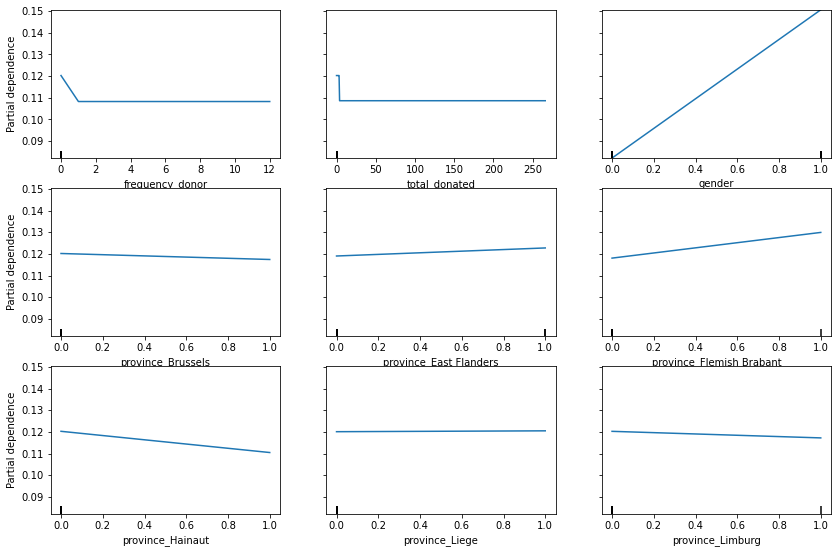

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
# weathersituation (1=clear, 2=cloudy, 3=rain/snow)
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=XG, X=shap_train_X, features=[0, 1, 28, 29, 30, 31, 32, 33, 34], ax=ax)
fig.tight_layout(pad=2.0)

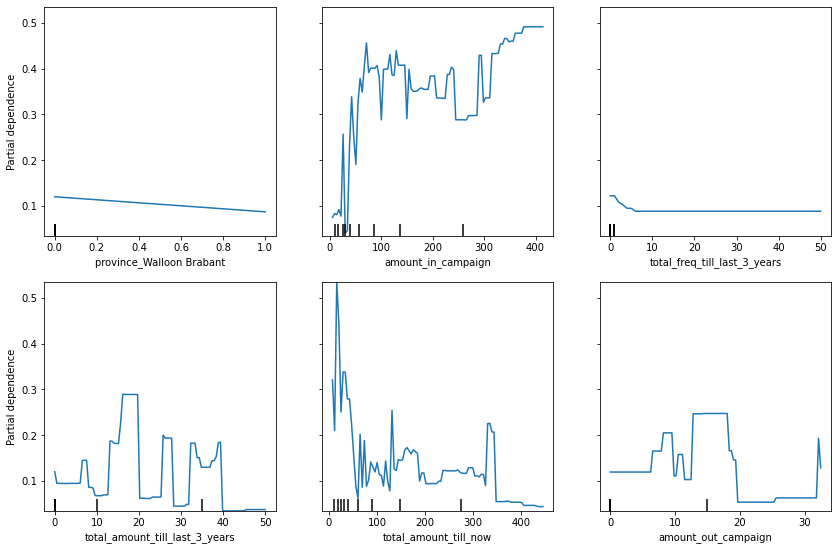

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=XG, X=shap_train_X, features=[38, 50, 52, 51, 46, 48], ax=ax)
fig.tight_layout(pad=2.0)

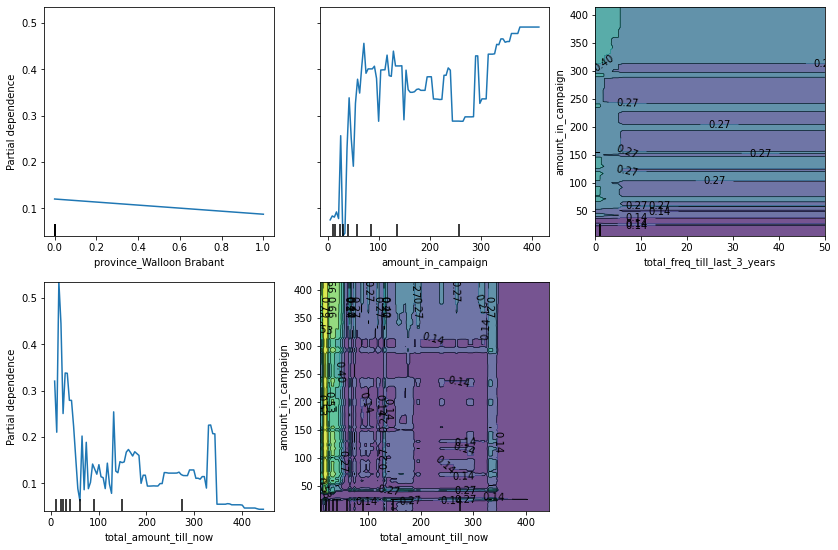

In [ ]:
#38, 50, 52, 51, 46, 48
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=XG, X=shap_train_X, features=[38, 50, (52, 50), 46, (46,50)], ax=ax)
fig.tight_layout(pad=2.0)

In [ ]:
feat_imp = pd.concat([rf_feat,xg_feat,bt_feat], axis=1)
fi_mean = feat_imp.transpose().describe().iloc[1:2].transpose().round(4)

feat_imp = pd.concat([feat_imp,fi_mean], axis=1)
feat_imp = feat_imp.sort_values(by=['mean'], ascending=False).head(15)

x_cols = feat_imp.index

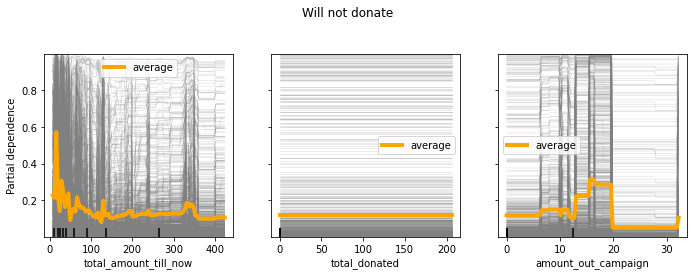

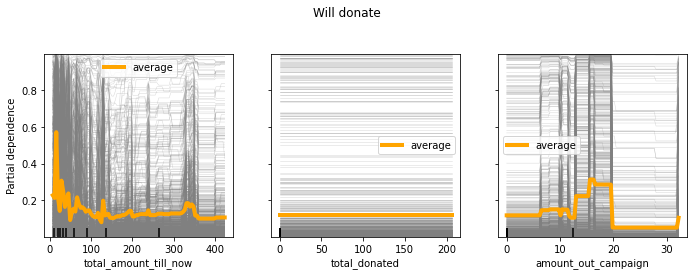

In [ ]:
# target 0
fig, ax = plt.subplots(figsize=(10, 4))
ice = PartialDependenceDisplay.from_estimator(estimator=XG,
                        X=X_train,
                        features=[46,1,48],
                        target=0,
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax)
fig.suptitle("Will not donate")
fig.tight_layout(pad=2.0)

# target 1
fig1, ax1 = plt.subplots(figsize=(10, 4))
ice = PartialDependenceDisplay.from_estimator(estimator=XG,
                        X=X_train,
                        features=[46,1,48],
                        target=1,
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax1)
fig1.suptitle("Will donate")
fig1.tight_layout(pad=2.0)

In [ ]:
train = gift_base_6169
test = gift_base_7244

feat_imp = pd.concat([rf_feat,xg_feat,bt_feat], axis=1)
fi_mean = feat_imp.transpose().describe().iloc[1:2].transpose().round(4)

feat_imp = pd.concat([feat_imp,fi_mean], axis=1)
feat_imp = feat_imp.sort_values(by=['mean'], ascending=False).head(15)

x_cols = feat_imp.index

y_col = ['target']

X=gift_base_6169[x_cols]
y=gift_base_6169[y_col]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [ ]:
X_train.shape

(6365, 15)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

tf.random.set_seed(123)

model = keras.Sequential([
    keras.layers.Dense(17, input_shape=(15,), activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
])

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, workers=2, shuffle=42, epochs=1000, batch_size=3)

Epoch 1/1000
2122/2122 [==============================] - 2s 863us/step - loss: 0.5425 - accuracy: 0.8628
Epoch 2/1000
2122/2122 [==============================] - 2s 894us/step - loss: 0.4844 - accuracy: 0.8727
Epoch 3/1000
2122/2122 [==============================] - 2s 925us/step - loss: 0.4130 - accuracy: 0.8713
Epoch 4/1000
2122/2122 [==============================] - 2s 899us/step - loss: 0.4158 - accuracy: 0.8746
Epoch 5/1000
2122/2122 [==============================] - 2s 871us/step - loss: 0.3990 - accuracy: 0.8727
Epoch 6/1000
2122/2122 [==============================] - 2s 889us/step - loss: 0.3828 - accuracy: 0.8756
Epoch 7/1000
2122/2122 [==============================] - 2s 908us/step - loss: 0.3695 - accuracy: 0.8764
Epoch 8/1000
2122/2122 [==============================] - 2s 910us/step - loss: 0.3589 - accuracy: 0.8760
Epoch 9/1000
2122/2122 [==============================] - 2s 914us/step - loss: 0.3538 - accuracy: 0.8775
Epoch 10/1000
2122/2122 [=====================

In [ ]:
#Evaluate model
scores = model.evaluate(X_test, y_test)
scores[1]*100

50/50 [==============================] - 0s 909us/step - loss: 0.3763 - accuracy: 0.8769


87.6884400844574

In [ ]:
yp = model.predict(X_test)

y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1407
           1       0.42      0.15      0.22       185

    accuracy                           0.88      1592
   macro avg       0.66      0.56      0.57      1592
weighted avg       0.84      0.88      0.85      1592



Text(69.0, 0.5, 'Truth')

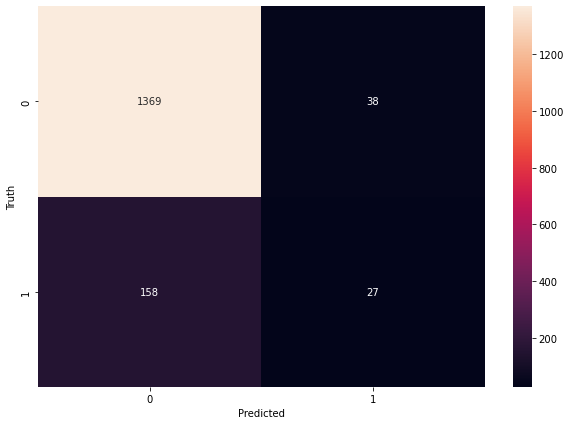

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
X_7244=test[x_cols]
y_7244=test[y_col]

In [ ]:
yp = model.predict(X_7244)

y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_7244,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     25428
           1       0.03      0.08      0.04       217

    accuracy                           0.97     25645
   macro avg       0.51      0.53      0.51     25645
weighted avg       0.98      0.97      0.98     25645



Text(69.0, 0.5, 'Truth')

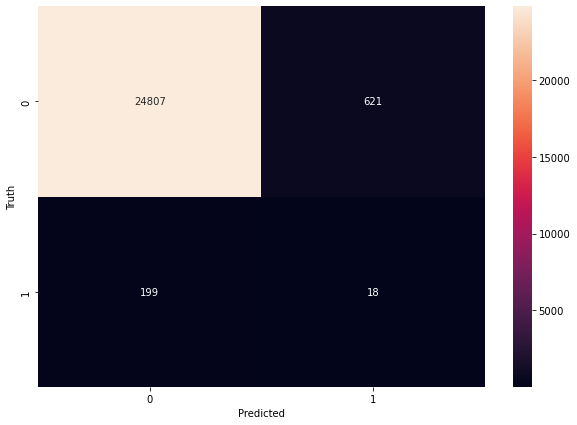

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_7244,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [96]:
X = unseen[x_cols]

In [116]:
XG_proba = XG.predict_proba(X)
boosted_proba = boostedTree.predict_proba(X)

In [136]:
combined = (np.array(XG_proba) + np.array(boosted_proba)) / 2

In [137]:
new_campaign_proba = combined[:,1]


In [138]:
new_campaign_proba = pd.DataFrame(new_campaign_proba, columns = ['proba'])

In [139]:
new_campaign = unseen

In [140]:
new_campaign = pd.merge(new_campaign, new_campaign_proba, left_index=True, right_index=True)
new_campaign.drop("Unnamed: 0", axis =1, inplace=True)

In [143]:
new_campaign = sqldf.run("""
select
*,
case when proba >.6 then 1 else 0 end as prediction
from new_campaign
""")


In [145]:
sqldf.run("""
select
prediction,
count(*) 
from new_campaign
group by prediction
""")


,prediction,count(*)
0,0,26189
1,1,333
